#  Inventory Management Dashboard and Analysis

## <mark>1. Read & describe the data 

In [81]:
# PeakFit_analysis csv data reading
import pandas as pd
import numpy as np

import altair as alt
import panel as pn
import plotly.graph_objects as go
import plotly.express as px
pn.extension('plotly')
ACCENT = "teal"


In [82]:
df = pd.read_excel(r'D:\K_REPO\Depi_freelanceYard\PeakFit Essentials.xlsx',sheet_name='Sheet1')
df.sort_values(by="Date").head(5)

,Date,Time,Item ID,Category,Responsible Staff,Expected Quantity,Actual Quantity,Expired Items,Returned Items,Items Out for Sales,Items Out for Quality Control,Items Out for Events
80,2024-01-01,Evening,ITM003,CTG003,Andrew Cauchi,34,31,4,3,7,10,12
171,2024-01-01,Evening,ITM005,CTG003,Jean-Pierre Ellul,47,44,4,2,7,9,12
556,2024-01-01,Evening,ITM005,CTG003,Andrew Cauchi,52,53,5,2,6,9,12
932,2024-01-01,Afternoon,ITM003,CTG003,Aaron Vella,41,37,5,3,7,9,12
1871,2024-01-01,Morning,ITM006,CTG001,Aaron Vella,44,39,4,3,6,10,12


## <mark>2. Clean the data 

In [83]:
#drop unusfull columns
df = df.drop(columns=['Expired Items','Returned Items','Items Out for Sales','Items Out for Quality Control','Items Out for Events'])

In [84]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

In [85]:
#replace expected & actual with stocked quantity
#make column for Inventory Discrepancy
df['Inventory Discrepancy'] =  df['Actual Quantity'] - df['Expected Quantity']
df = df.drop(columns=['Expected Quantity',	'Actual Quantity'  ])
print(df['Inventory Discrepancy'].sum())  #total Inventory Discrepancy in 10 monthes [ -N : missing , +N more than expeted  ] 
df.head()

42


,Date,Time,Item ID,Category,Responsible Staff,Inventory Discrepancy
0,2024-05-29,Evening,ITM006,CTG001,Robert Tabone,-4
1,2024-08-23,Afternoon,ITM004,CTG001,Simon Fenech,-5
2,2024-05-12,Evening,ITM001,CTG001,Jean-Pierre Ellul,0
3,2024-03-27,Evening,ITM003,CTG003,Andrew Cauchi,-4
4,2024-09-24,Evening,ITM002,CTG002,Robert Tabone,2


In [86]:
df['Month'] = df['Date'].dt.month_name()


In [87]:
print(df['Inventory Discrepancy'].sum())

42


### the new data discription

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   2000 non-null   datetime64[ns]
 1   Time                   2000 non-null   object        
 2   Item ID                2000 non-null   object        
 3   Category               2000 non-null   object        
 4   Responsible Staff      2000 non-null   object        
 5   Inventory Discrepancy  2000 non-null   int64         
 6   Month                  2000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 109.5+ KB


In [89]:
df.describe(include='all')

,Date,Time,Item ID,Category,Responsible Staff,Inventory Discrepancy,Month
count,2000,2000,2000,2000,2000,2000.00000,2000
unique,NaN,3,6,3,6,NaN,9
top,NaN,Morning,ITM001,CTG001,Jean-Pierre Ellul,NaN,March
freq,NaN,679,359,1011,368,NaN,247
mean,2024-05-16 21:35:16.800000256,NaN,NaN,NaN,NaN,0.02100,NaN
min,2024-01-01 00:00:00,NaN,NaN,NaN,NaN,-5.00000,NaN
25%,2024-03-09 00:00:00,NaN,NaN,NaN,NaN,-3.00000,NaN
50%,2024-05-17 12:00:00,NaN,NaN,NaN,NaN,0.00000,NaN
75%,2024-07-25 00:00:00,NaN,NaN,NaN,NaN,3.00000,NaN
max,2024-09-30 00:00:00,NaN,NaN,NaN,NaN,5.00000,NaN


Date started 2024-01-01  ended 2024-09-30 with 2000 record .

time 3 shifts per day (morning, afternoon, evening).

item ID are only 6 items (Dumbbells, Yoga Mat, Resistance Bands, Protein Powder, Foam Roller, Kettlebells).

category are only 3 items , but 4 in category sheet (Strength Training Equipment, fitness accessories, strength training equipment). there is an issue (miss leading inputs)

responsible staff are only 6 (['Robert Tabone', 'Simon Fenech', 'Jean-Pierre Ellul','Andrew Cauchi', 'Aaron Vella', 'Franklin Attard']).

and no nulls in the data



In [90]:
# fixing category
# assinge ITM001 , ITM003 , ITM006 to ctg001  as they all strength training Items
df.loc[df['Item ID'].isin(['ITM001', 'ITM003', 'ITM006']), 'Category'] = 'CTG001'

# assinge ITM004 as CTG004 ( protein poweder is supplements )
df.loc[df["Item ID"].isin(["ITM004"]), "Category"]= "CTG003"

#assinge ITM005 as CTG005 (foam rollers are recovery tools)
df.loc[df["Item ID"].isin(["ITM005"]), "Category"]="CTG004"

df['Category'].unique()


array(['CTG001', 'CTG003', 'CTG002', 'CTG004'], dtype=object)

## <mark>3. Data proccessing

#### calender heatmap (Heat_fig) ####

In [91]:
# Convert DateTime to datetime format
df['DateTime'] = pd.to_datetime(df['Date'])

# Extract Month and Day
df['Month'] = df['DateTime'].dt.strftime('%B')  # Month name
df['Day'] = df['DateTime'].dt.day  # Day of month

# Aggregate data by Day and Month (sum of Inventory Discrepancy)
df_agg = df.groupby(['Day', 'Month'])['Inventory Discrepancy'].sum().reset_index()

# Create pivot table for heatmap
heatmap_data = df_agg.pivot(index='Day', columns='Month', values='Inventory Discrepancy')

# Fill NaN values with 0 (days with no Inventory Discrepancy)
heatmap_data = heatmap_data.fillna(0)

# Define month order for proper sorting
month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October"]

# Filter to only include months that are in our data
available_months = [month for month in month_order if month in heatmap_data.columns]
heatmap_data = heatmap_data.reindex(columns=available_months)
df_agg.head()

,Day,Month,Inventory Discrepancy
0,1,April,5
1,1,August,0
2,1,February,9
3,1,January,-13
4,1,July,-1


In [92]:

# Create the heatmap
Heat_fig = px.imshow(
    heatmap_data.values,
    labels=dict(x="Month", y="Day", color="Inventory Discrepancy"),
    x=heatmap_data.columns,
    y=heatmap_data.index,
    color_continuous_scale="RdBu",  # Changed to Reds as Inventory Discrepancy are positive now
    text_auto=True  # Display values in the cells
)

Heat_fig.update_layout(
    title="Inventory Discrepancy/day Heatmap",
    xaxis_title="Month",
    yaxis_title="Day of Month",

    yaxis=dict(
        range=[1, 31],  # Explicitly reverse the order (assuming max day is 31)
        autorange=False  # Disable automatic range adjustment
        ),  # Keep day labels in correct order
   
    width=700,  # Set width
    height=600,   # Set height
    plot_bgcolor="black",  # Set plot background to black
    paper_bgcolor="white",  # Set entire figure background to black
    font=dict(color="black")  # Set text color to white for contrast
    
)

# To display the figure

Heat_fig

#made a calnder as heatmap, and found :

at (25/07) 31 unexpected item found 

at (30/05) & 03/08 highest missing record at -23 item 

#### by weekday (Bar_fig)

In [93]:
# Extract weekday name
df["Weekday"] = df["Date"].dt.day_name()
# Group by weekday and sum Inventory Discrepancy
df_grouped = df.groupby("Weekday")["Inventory Discrepancy"].sum().reset_index()
# Define weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Create a category type with our custom order
df_grouped["Weekday"] = pd.Categorical(df_grouped["Weekday"], categories=weekday_order, ordered=True)

# Sort by our ordered category
df_grouped = df_grouped.sort_values("Weekday")

# # Create color sequence to match your original
# colors = ["skyblue", "orange", "green", "red", "purple", "pink", "brown"]

df.head()

,Date,Time,Item ID,Category,Responsible Staff,Inventory Discrepancy,Month,DateTime,Day,Weekday
0,2024-05-29,Evening,ITM006,CTG001,Robert Tabone,-4,May,2024-05-29,29,Wednesday
1,2024-08-23,Afternoon,ITM004,CTG003,Simon Fenech,-5,August,2024-08-23,23,Friday
2,2024-05-12,Evening,ITM001,CTG001,Jean-Pierre Ellul,0,May,2024-05-12,12,Sunday
3,2024-03-27,Evening,ITM003,CTG001,Andrew Cauchi,-4,March,2024-03-27,27,Wednesday
4,2024-09-24,Evening,ITM002,CTG002,Robert Tabone,2,September,2024-09-24,24,Tuesday


In [94]:
# Create the bar chart
Bar_fig = px.bar(
    df_grouped,
    x="Weekday",
    y="Inventory Discrepancy",
    title="Inventory Discrepancy by Day of the Week",
    color="Inventory Discrepancy",  # Color by value
    color_continuous_scale=['red', 'blue'],  # Red for negative, blue for positive
    labels={"Weekday": "Day of the Week", "Inventory Discrepancy": "Total Inventory Discrepancy"}
)

# Update layout for dark background
Bar_fig.update_layout(
    plot_bgcolor="black",  # Set plot background to black
    paper_bgcolor="black",  # Set entire figure background to black
    font=dict(color="white")  # Set text color to white for contrast
)

# Add grid lines
Bar_fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(255,255,255,0.2)')

component0 = pn.panel(Bar_fig)
# Display the figure
Bar_fig


allover the week tuesdays were for losing items . about 94 item were missed   

### staff sum of recorded stocks  allover the year (Bar2_fig)

In [95]:
#Inventory Discrepancy per staff
df_miss_perstaff=df.groupby("Responsible Staff").agg({
    'Inventory Discrepancy': 'sum'
})
df_miss_perstaff.head(10)

,Inventory Discrepancy
Responsible Staff,
Aaron Vella,8
Andrew Cauchi,28
Franklin Attard,-39
Jean-Pierre Ellul,-11
Robert Tabone,31
Simon Fenech,25


franklin & jean were responsible for most missing recordes  ( 39 , 11)

### shifts and responsible staff (Line_fig)

In [96]:
#staff per shift
df_staff_shifts = df.groupby(["Responsible Staff", "Time"]).size().unstack(fill_value=0)
df_staff_shifts["Total Shifts"] = df_staff_shifts.sum(axis=1)
df_staff_shifts.head(10)

Time,Afternoon,Evening,Morning,Total Shifts
Responsible Staff,,,,
Aaron Vella,103,107,104,314
Andrew Cauchi,110,106,96,312
Franklin Attard,115,98,106,319
Jean-Pierre Ellul,106,140,122,368
Robert Tabone,106,124,123,353
Simon Fenech,104,102,128,334


In [97]:

# Data
staff = ["Aaron Vella", "Andrew Cauchi", "Franklin Attard", "Jean-Pierre Ellul", "Robert Tabone", "Simon Fenech"]
shifts = ["Morning", "Afternoon", "Evening"]
morning = [104, 96, 106, 122, 123, 128]
afternoon = [103, 110, 115, 106, 106, 104]
evening = [107, 106, 98, 140, 124, 102]

# Define custom colors for each staff member
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

# Create figure with specified name
Line_fig = go.Figure()

# Add traces for each staff member with specific colors
for i, staff_name in enumerate(staff):
    y_values = [morning[i], afternoon[i], evening[i]]
    Line_fig.add_trace(go.Scatter(
        x=shifts,
        y=y_values,
        mode='lines+markers',
        name=staff_name,
        line=dict(color=colors[i], width=2),
        marker=dict(color=colors[i], size=8),
        hovertemplate='<b>%{x} Shift</b><br>' + 
                     f'{staff_name}: ' + '%{y}<extra></extra>'
    ))

# Update layout
Line_fig.update_layout(
    title="Shift Distribution Across Staff Members",
    xaxis_title="Shifts",
    yaxis_title="Shift Distribution",
    legend_title="Staff Members",
    height=600,
    width=800,
    hovermode="closest"
)

# Add grid lines for better readability
Line_fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)')
Line_fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)')

# Show the figure
Line_fig

### final stocks of Items

In [98]:
df_stocks = df.groupby(["Item ID", "Category"])["Inventory Discrepancy"].agg(sum)
pd.DataFrame(df_stocks).head(10)

C:\Users\S\AppData\Local\Temp\ipykernel_3408\3132821364.py:1: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



,,Inventory Discrepancy
Item ID,Category,
ITM001,CTG001,16
ITM002,CTG002,-71
ITM003,CTG001,35
ITM004,CTG003,35
ITM005,CTG004,-42
ITM006,CTG001,69


ITM002 & ITM005 are the missed itmes : (Yoga Mat: 71 missing , foam rollers: 42 missing) 

## the interactive bar chart (fig)

In [99]:
#make a df to customize
activ_df = pd.DataFrame(df[["Time", "Month","Responsible Staff","Category","Inventory Discrepancy"]])
activ_df.head()

,Time,Month,Responsible Staff,Category,Inventory Discrepancy
0,Evening,May,Robert Tabone,CTG001,-4
1,Afternoon,August,Simon Fenech,CTG003,-5
2,Evening,May,Jean-Pierre Ellul,CTG001,0
3,Evening,March,Andrew Cauchi,CTG001,-4
4,Evening,September,Robert Tabone,CTG002,2


In [100]:
# Create a vertical radio button group
list_dropdown = pn.widgets.RadioButtonGroup(
    name="Select Data on X axis",
    options=["Date", "Month", "Time", "Responsible Staff", "Category", "Item ID" , "Weekday"],
    description="select data type to calculate stock for!",
    button_style='outline'
)

# Wrap in a Panel component (optional, but can help with layout)
component1 = pn.panel(list_dropdown)
list_dropdown

BokehModel(combine_events=True, render_bundle={'docs_json': {'45a36b19-d5a7-41f8-881d-3e1239c3249f': {'version…

In [246]:

@pn.depends(list_dropdown)
def inter_bar(list_dropdown):
    # Aggregate data for plotting
    grouped_df = df.groupby(list_dropdown)['Inventory Discrepancy'].sum().reset_index()
    
    # Ensure 'Month' column is ordered correctly if the dropdown is "Month"
    if list_dropdown == "Month":
        grouped_df["Month"] = pd.Categorical(grouped_df["Month"], categories=month_order, ordered=True)
        grouped_df = grouped_df.sort_values("Month")

    # Set title dynamically
    tit = "Missing/overstock by item ID" if list_dropdown == "item ID" else f'Inventory Discrepancy by {list_dropdown}'

    # Create the figure using Plotly Express
    fig = px.bar(
        grouped_df,
        x=list_dropdown,
        y="Inventory Discrepancy",
        title=tit,
        color="Inventory Discrepancy",  # Color by category
        color_continuous_scale=['red', ACCENT],  # Adjust color scale
    )
        # Improve layout
    fig.update_layout(
        xaxis_title=list_dropdown,
        yaxis_title="Total Inventory Discrepancy",
        plot_bgcolor="#f8f8f8",  
        paper_bgcolor="#f8f8f8",  
        font=dict(color="black"),  
        xaxis=dict(gridcolor='lightgray', showgrid=True),
        yaxis=dict(gridcolor='black'),
        width=1200,  
        height=500,
    )
    
    return fig

component2 = pn.panel(inter_bar)  # Assign to Panel

inter_bar("Month")  # Show ordered months

    


## creating KPIs cards 

total actual stock= 94489

total expected stock= 94447

total overstock= 42 (.044% of the stock)

ITM002(Yoga Mat) lost 71 pieces , ITM005(Foam Roller) lost 42 piece,  totlal= 113

the over stock items (ITM001: 16 , ITM003: 35 , ITM004: 35 , ITM006: 69), total= 155

In [245]:
ACCENT = "teal"

styles = {
    "box-shadow": "rgba(50, 50, 93, 0.25) 0px 6px 12px -2px, rgba(0, 0, 0, 0.3) 0px 3px 7px -3px",
    "border-radius": "10px",
    "padding": "10px",
    "background": "#DCEFF0",
    'box-shadow': "3px 3px 6px rgba(0,0,0,0.3)",
    "width": "385px",
    "height": "220px" 
    }               # a dict to use later in the cards 


In [345]:
# KPIs cards
cards= pn.FlexBox(



    #'Highest miss/day
    pn.indicators.Number(name='The worst-performing day <br> (03.Aug & 30.May)📉',
    value=23, 
    format='<span style="font-size:1.5em;">{value}</span>'
       '<span style="font-size:0.7em;"> items</span>',
    colors=[(1, 'black')],
    styles=styles,
    ),

    pn.indicators.Number(
    name='Franklin Attard <br> the biggest Loser',
    value=39,
    # Embed HTML to style the units separately:
    format='<span style="font-size:1.5em;">{value}</span>'
           '<span style="font-size:0.7em;"> items</span>',
    colors=[(0, ACCENT)]
    ,styles=styles
    ),

    pn.indicators.Number(
    name='Morning shift had the <br> hieghest missing rate',
    value=84,
    # Embed HTML to style the units separately:
    format='<span style="font-size:1.5em;">{value}</span>'
           '<span style="font-size:0.7em;"> items</span>',
    colors=[(0, ACCENT)]
    ,styles=styles
    )
)



In [239]:
cards

BokehModel(combine_events=True, render_bundle={'docs_json': {'1183480e-5217-4646-99d1-1ec3fbe4428d': {'version…

### making cards of stock discrepancy

In [240]:


# Data for missing and overstocked items
missing_items = {
    "Yoga Mat": 71,
    "Foam Roller": 42
}
overstock_items = {
    "Dumbbells": 16,
    "Resistance Band": 35,
    "Jump Rope": 35,
    "Kettlebell": 69
}

# Convert to DataFrame
df_missing = pd.DataFrame(missing_items.items(), columns=["Item", "Quantity Lost"])
df_overstock = pd.DataFrame(overstock_items.items(), columns=["Item", "Quantity Overstocked"])


In [241]:

# Create bar plots
fig_missing = px.bar(
    df_missing, 
    x="Item", 
    y="Quantity Lost", 
    title="Missing Items(max:71, sum:113)", 
    color="Quantity Lost",
    color_continuous_scale=[(0, "lightcoral"), (0.5, "red"), (1, "darkred")]

)



fig_overstock = px.bar(
    df_overstock, 
    x="Item", 
    y="Quantity Overstocked", 
    title="Overstocked Items(max:69, sum:155)", 
    color="Quantity Overstocked",
    color_continuous_scale="blues"
)

# Improve layout
fig_missing.update_layout(paper_bgcolor="#DCEFF0", plot_bgcolor="#DCEFF0", width=295, height=295, coloraxis_showscale=False,title_font=dict(size=16))
fig_overstock.update_layout(paper_bgcolor="#DCEFF0", plot_bgcolor="#DCEFF0", width=295, height=295,coloraxis_showscale=False,title_font=dict(size=14) )

component3=pn.panel(fig_missing)
component4=pn.panel(fig_overstock)


In [242]:

# Convert to DataFrame
df_missing = pd.DataFrame(missing_items.items(), columns=["Item", "Quantity Lost"])
df_overstock = pd.DataFrame(overstock_items.items(), columns=["Item", "Quantity Overstocked"])

# Create bar plots
fig_missing = px.bar(
    df_missing, 
    x="Item", 
    y="Quantity Lost", 
    title="Missing Items(max:71, sum:113)", 
    color="Quantity Lost",
    color_continuous_scale=[(0, "lightcoral"), (0.5, "red"), (1, "darkred")]
)


missing_items_indicator = pn.indicators.Number(
    name="Missing Items",  # Title
    value=113,  # Number displayed
    format="{:.0f}",  # No decimal places
    colors=[(50, "red")],  # Customize color if needed
    font_size="20pt"  # Adjust font size
)


fig_overstock = px.bar(
    df_overstock, 
    x="Item", 
    y="Quantity Overstocked", 
    title="Overstocked Items(max:69, sum:155)", 
    color="Quantity Overstocked",
    color_continuous_scale="blues"
)

# Improve layout
fig_missing.update_layout(
    paper_bgcolor="#DCEFF0",
    plot_bgcolor="#DCEFF0",
    width=600,
    height=295,
    coloraxis_showscale=False,
    title_font=dict(size=28, color="#8B0000")  # Set title color to red
)

fig_overstock.update_layout(
    paper_bgcolor="#DCEFF0",
    plot_bgcolor="#DCEFF0",
    width=600,
    height=295,
    coloraxis_showscale=False,
    title_font=dict(size=28, color="teal")  # Set title color to blue
)


component3=pn.panel(fig_missing)
component4=pn.panel(fig_overstock)
comp5=pn.panel(missing_items_indicator)


## Dashboard layout

In [381]:
styles2 = {
    "box-shadow": "rgba(50, 50, 93, 0.25) 0px 6px 12px -2px, rgba(0, 0, 0, 0.3) 0px 3px 7px -3px",
    "border-radius": "10px",
    "padding": "10px",
    "background": "#DADADA",
    'box-shadow': "3px 3px 6px rgba(0,0,0,0.3)",
    "width": "280px",
    "height": "80px" 
    }  
sidebar_card1 = pn.indicators.Number(
    name=("Total records: 2000"),
    styles=styles2
    
)

sidebar_card2 = pn.indicators.Number(
    name=("Start date: 01-01-2024  To 30-09-2024"),
    styles=styles2
)

insight1 = pn.indicators.Number(
    name="More managment on Morinig shift is essential ",
    styles={"background": "#6AB187", "border-radius": "10px", "padding": "10px", "width": "300" , "height":"120px"}
)

insight2 = pn.indicators.Number(
    name="light items must be moved in more watched ereas ",
    styles={"background": "#6AB187", "border-radius": "10px", "padding": "10px", "width": "300" , "height":"120px"}
)

insight3 = pn.indicators.Number(
    name="need better rocording system to overcome the overstocking issue",
    styles={"background": "#6AB187", "border-radius": "10px", "padding": "10px", "width": "300" , "height":"120px"}
)


<>:12: SyntaxWarning:

invalid escape sequence '\K'

C:\Users\S\AppData\Local\Temp\ipykernel_3408\1352288665.py:12: SyntaxWarning:

invalid escape sequence '\K'



EditableTemplate
    [editor] TemplateEditor()
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [browser_info] BrowserInfo()
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [nav-1787242643232] Markdown(str)
    [nav-1787242642752] Image(str, align='center', width=290)
    [nav-1787095402928] Number(name='Total records: 2000', styles={'box-shadow': '3px 3px 6p...})
    [nav-1787221463104] Number(name='Start date: 0..., styles={'box-shadow': '3px 3px 6p...})
    [nav-1787221462384] Number(name='More managment o..., styles={'background': '#6AB187', ...})
    [nav-1787221467664] Number(name='light items m..., styles={'background': '#6AB187', ...})
    [nav-1787221465024] Number(name='need better r..., styles={'background': '#6AB187', ...})
    [main-1787243512336] Column
        [0] Row(sizing_mode='stretch_width')
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [1] Row(sizing_mode='stretch_width')
            [0] FlexBox(objects=[Number(colors=[(1, ...], sizing_mode='stretch_width')
        [2] Column
            [0] Row(sizing_mode='stretch_width')
                [0] ParamFunction(function, _pane=Plotly, defer_load=False)
            [1] Row(sizing_mode='stretch_width')
                [0] Spacer(width=200)
                [1] RadioButtonGroup(button_style='outline', description='select data t..., name='Select Data on X axis', options=['Date', 'Month', ...], value='Date')
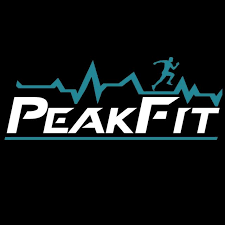

In [389]:
import panel as pn

# Create the template
template = pn.template.EditableTemplate(
    title="PeakFit Inventory Analysis Interactive Dashboard",
    theme="default",
    header_background="#1C4E80",  # Header background color
    
    sidebar=[
        pn.pane.Markdown("Inventory Infos & Insights"),  # Sidebar title
        pn.pane.Image(
            "D:\K_REPO\Depi_freelanceYard\images.png",
            width=290,  # Adjust width as needed
            align="center"
        ),
        sidebar_card1,
        sidebar_card2,
        insight1,
        insight2,
        insight3
    ],
    sidebar_width=300,  # Adjust sidebar width
)



# Add main content
template.main.append(
    pn.Column(
        # Row 1: Charts
        pn.Row(component3, component4, sizing_mode="stretch_width"),  

        # Row 2: KPI Cards
        pn.Row(cards, sizing_mode="stretch_width"),  

        # Row 3: Stacked Components
        pn.Column(
            pn.Row(component2, sizing_mode="stretch_width"),  
            pn.Row(pn.Spacer(width=200), component1, sizing_mode="stretch_width"),  
        ),
    )
)

template.servable()
